<a href="https://colab.research.google.com/github/jaehyun0220/Colab/blob/master/health_dental_ver3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import os, sys

import re

import tensorflow as tf

In [4]:
#데이터 전처리 관련 라이브러리 로드
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit

#모델 알고리즘 로드
from sklearn import svm, tree
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Deep Learning Model 로드
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation 
from keras.wrappers.scikit_learn import KerasClassifier


#HyperParameter Tuning을 위한 라이브러리 로드
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#모델 평가를 위한 라이브러리 로드
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn import model_selection

#수학 & 통계 관련 라이브러리 로드
import scipy.stats as st
from collections import Counter

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [5]:
#Visualization
import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도
import seaborn as sns

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')

# 한글 글꼴 설치
!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

# 우선 fm._rebuild() 를 해주고
fm._rebuild()

Selecting previously unselected package fonts-nanum.
(Reading database ... 131183 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
NanumGothic Eco


In [6]:
# Auth 인증 및 Google Drive 활용 Data load
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/gdrive', force_remount=True)

# Google Drive 내 Custom Class 경로 지정
import sys
sys.path.insert(0, '/gdrive/My Drive/CustomClasses')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [7]:
# !ls /gdrive/My\ Drive/data/sds
!ls ../gdrive/My\ Drive/data/sds

NHIS_OPEN_GJ_2015.CSV  NHIS_OPEN_GJ_2016.csv  NHIS_OPEN_GJ_2017.CSV


## 파일 Read 및 기초 탐색

In [8]:
df_raw_2016 = pd.read_csv('../gdrive/My Drive/data/sds/NHIS_OPEN_GJ_2016.csv', encoding = 'euc-kr')
df_raw_2017 = pd.read_csv('../gdrive/My Drive/data/sds/NHIS_OPEN_GJ_2017.CSV', encoding = 'euc-kr')
display(df_raw_2016.head())
display(df_raw_2017.head())

,기준년도,가입자일련번호,성별코드,연령대코드(5세단위),시도코드,신장(5Cm단위),체중(5Kg단위),허리둘레,시력(좌),시력(우),청력(좌),청력(우),수축기혈압,이완기혈압,식전혈당(공복혈당),총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피,흡연상태,음주여부,구강검진 수검여부,치아우식증유무,결손치유무,치아마모증유무,제3대구치(사랑니)이상,치석,데이터공개일자
0,2016,1,1,10,27,175.0,75.0,86.0,1.0,1.2,1.0,1.0,140.0,90.0,91.0,263.0,196.0,46.0,177.0,16.0,1.0,0.9,27.0,30.0,45.0,3.0,NaN,0,NaN,NaN,NaN,NaN,NaN,20171219
1,2016,2,2,11,41,160.0,65.0,85.0,1.5,1.2,1.0,1.0,138.0,80.0,105.0,185.0,262.0,35.0,122.0,13.1,1.0,0.9,18.0,17.0,19.0,1.0,NaN,0,NaN,NaN,NaN,NaN,NaN,20171219
2,2016,3,2,11,43,150.0,55.0,80.0,1.5,1.5,1.0,1.0,138.0,88.0,93.0,246.0,186.0,59.0,150.0,13.6,1.0,0.7,23.0,19.0,64.0,1.0,NaN,0,NaN,NaN,NaN,NaN,NaN,20171219
3,2016,4,1,12,48,175.0,70.0,85.0,1.2,1.2,1.0,1.0,124.0,76.0,93.0,179.0,79.0,40.0,123.0,16.8,1.0,1.0,20.0,39.0,69.0,2.0,NaN,1,NaN,NaN,NaN,NaN,1.0,20171219
4,2016,5,2,6,11,160.0,50.0,67.0,0.4,0.5,1.0,1.0,121.0,68.0,96.0,223.0,104.0,72.0,130.0,12.8,1.0,0.7,13.0,7.0,20.0,1.0,NaN,0,NaN,NaN,NaN,NaN,NaN,20171219


,기준년도,가입자일련번호,성별코드,연령대코드(5세단위),시도코드,신장(5Cm단위),체중(5Kg 단위),허리둘레,시력(좌),시력(우),청력(좌),청력(우),수축기혈압,이완기혈압,식전혈당(공복혈당),총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피,흡연상태,음주여부,구강검진 수검여부,치아우식증유무,결손치유무,치아마모증유무,제3대구치(사랑니)이상,치석,데이터공개일자
0,2017,1,1,13,46,170.0,65.0,91.0,1.0,1.2,1.0,1.0,158.0,88.0,95.0,178.0,161.0,43.0,102.0,15.9,1.0,1.0,19.0,41.0,25.0,3.0,0.0,1,NaN,NaN,NaN,NaN,1.0,20181126
1,2017,2,2,8,41,150.0,45.0,73.4,1.2,1.0,1.0,1.0,110.0,79.0,98.0,255.0,82.0,62.0,176.0,10.7,1.0,0.9,16.0,13.0,10.0,1.0,0.0,1,NaN,NaN,NaN,NaN,1.0,20181126
2,2017,3,1,8,45,175.0,75.0,94.0,1.0,0.8,1.0,1.0,130.0,89.0,88.0,211.0,271.0,64.0,92.0,16.1,1.0,1.1,45.0,62.0,136.0,1.0,0.0,1,NaN,NaN,NaN,NaN,0.0,20181126
3,2017,4,2,12,11,155.0,55.0,67.5,0.9,1.0,1.0,1.0,138.0,90.0,76.0,160.0,97.0,52.0,88.0,13.4,1.0,0.6,21.0,24.0,30.0,1.0,1.0,0,NaN,NaN,NaN,NaN,NaN,20181126
4,2017,5,1,8,41,175.0,75.0,93.0,1.5,1.5,1.0,1.0,128.0,80.0,97.0,253.0,182.0,47.0,169.0,16.1,1.0,1.1,37.0,62.0,68.0,3.0,0.0,0,NaN,NaN,NaN,NaN,NaN,20181126


### 컬럼명 정제 및 기초 탐색

In [9]:
# df_raw_2016.rename(columns=lambda x: x.replace(' ', ''), inplace=True)
# df_raw_2017.rename(columns=lambda x: x.replace(' ', ''), inplace=True)

df_raw_2016.rename(columns=lambda x: re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》 ]', '', x), inplace=True)
df_raw_2017.rename(columns=lambda x: re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》 ]', '', x), inplace=True)

display(df_raw_2016.sample(3))
display(df_raw_2017.sample(3))

,기준년도,가입자일련번호,성별코드,연령대코드5세단위,시도코드,신장5Cm단위,체중5Kg단위,허리둘레,시력좌,시력우,청력좌,청력우,수축기혈압,이완기혈압,식전혈당공복혈당,총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,혈청지오티AST,혈청지오티ALT,감마지티피,흡연상태,음주여부,구강검진수검여부,치아우식증유무,결손치유무,치아마모증유무,제3대구치사랑니이상,치석,데이터공개일자
458606,2016,458607,1,12,48,175.0,60.0,81.0,1.2,1.2,1.0,1.0,110.0,64.0,96.0,188.0,99.0,46.0,122.0,12.7,1.0,1.0,14.0,11.0,12.0,3.0,NaN,0,NaN,NaN,NaN,NaN,NaN,20171219
158685,2016,158686,2,13,28,160.0,55.0,85.0,0.7,0.7,1.0,1.0,110.0,69.0,168.0,218.0,216.0,45.0,129.0,14.0,1.0,0.8,27.0,45.0,44.0,1.0,NaN,1,NaN,NaN,NaN,NaN,0.0,20171219
338750,2016,338751,2,13,41,160.0,60.0,86.0,1.0,1.0,1.0,1.0,134.0,90.0,98.0,214.0,106.0,51.0,141.0,13.0,1.0,0.8,23.0,20.0,31.0,1.0,NaN,0,NaN,NaN,NaN,NaN,NaN,20171219


,기준년도,가입자일련번호,성별코드,연령대코드5세단위,시도코드,신장5Cm단위,체중5Kg단위,허리둘레,시력좌,시력우,청력좌,청력우,수축기혈압,이완기혈압,식전혈당공복혈당,총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,혈청지오티AST,혈청지오티ALT,감마지티피,흡연상태,음주여부,구강검진수검여부,치아우식증유무,결손치유무,치아마모증유무,제3대구치사랑니이상,치석,데이터공개일자
457943,2017,457944,2,11,11,150.0,55.0,80.0,1.2,1.2,1.0,1.0,133.0,80.0,83.0,204.0,73.0,65.0,124.0,12.6,1.0,0.6,16.0,16.0,13.0,1.0,0.0,0,NaN,NaN,NaN,NaN,NaN,20181126
836494,2017,836495,2,10,47,155.0,55.0,71.0,1.5,1.2,1.0,1.0,123.0,76.0,93.0,193.0,131.0,65.0,101.0,13.8,3.0,0.7,19.0,25.0,61.0,1.0,1.0,0,NaN,NaN,NaN,NaN,NaN,20181126
89524,2017,89525,2,11,26,145.0,50.0,72.1,0.9,0.9,1.0,1.0,112.0,67.0,86.0,176.0,81.0,64.0,95.0,14.3,1.0,0.7,28.0,33.0,26.0,1.0,1.0,0,NaN,NaN,NaN,NaN,NaN,20181126


In [10]:
print(df_raw_2016.columns)
print(df_raw_2017.columns)

Index(['기준년도', '가입자일련번호', '성별코드', '연령대코드5세단위', '시도코드', '신장5Cm단위', '체중5Kg단위',
       '허리둘레', '시력좌', '시력우', '청력좌', '청력우', '수축기혈압', '이완기혈압', '식전혈당공복혈당',
       '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '요단백', '혈청크레아티닌',
       '혈청지오티AST', '혈청지오티ALT', '감마지티피', '흡연상태', '음주여부', '구강검진수검여부', '치아우식증유무',
       '결손치유무', '치아마모증유무', '제3대구치사랑니이상', '치석', '데이터공개일자'],
      dtype='object')
Index(['기준년도', '가입자일련번호', '성별코드', '연령대코드5세단위', '시도코드', '신장5Cm단위', '체중5Kg단위',
       '허리둘레', '시력좌', '시력우', '청력좌', '청력우', '수축기혈압', '이완기혈압', '식전혈당공복혈당',
       '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '요단백', '혈청크레아티닌',
       '혈청지오티AST', '혈청지오티ALT', '감마지티피', '흡연상태', '음주여부', '구강검진수검여부', '치아우식증유무',
       '결손치유무', '치아마모증유무', '제3대구치사랑니이상', '치석', '데이터공개일자'],
      dtype='object')


## 구강검진검수자 데이터 기준 dataset 생성 - 불필요한 컬럼 제거

In [0]:
df_raw = pd.concat([df_raw_2016, df_raw_2017])
df_raw = df_raw[df_raw['구강검진수검여부']==1]

del_cols = ['기준년도', '가입자일련번호', '치아우식증유무', '결손치유무' ,'치아마모증유무','제3대구치사랑니이상','데이터공개일자', '음주여부', '구강검진수검여부']
df_raw.drop(columns=del_cols, axis=1, inplace=True)

In [12]:
display(df_raw.head())
df_raw.info()

,성별코드,연령대코드5세단위,시도코드,신장5Cm단위,체중5Kg단위,허리둘레,시력좌,시력우,청력좌,청력우,수축기혈압,이완기혈압,식전혈당공복혈당,총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,혈청지오티AST,혈청지오티ALT,감마지티피,흡연상태,치석
3,1,12,48,175.0,70.0,85.0,1.2,1.2,1.0,1.0,124.0,76.0,93.0,179.0,79.0,40.0,123.0,16.8,1.0,1.0,20.0,39.0,69.0,2.0,1.0
5,1,9,46,170.0,55.0,64.0,1.1,1.2,1.0,1.0,124.0,79.0,90.0,319.0,45.0,53.0,257.0,15.8,1.0,1.0,20.0,14.0,12.0,1.0,2.0
6,1,10,31,175.0,70.0,90.0,1.5,1.5,1.0,1.0,114.0,76.0,85.0,207.0,93.0,50.0,138.0,13.9,1.0,0.8,25.0,30.0,24.0,3.0,0.0
10,1,7,46,170.0,80.0,86.0,1.5,1.0,1.0,1.0,136.0,80.0,95.0,207.0,297.0,53.0,95.0,16.7,1.0,1.0,27.0,39.0,81.0,3.0,0.0
12,1,7,41,170.0,80.0,92.0,0.6,0.4,1.0,1.0,128.0,80.0,125.0,230.0,214.0,42.0,145.0,15.3,1.0,1.0,22.0,22.0,101.0,1.0,1.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 800512 entries, 3 to 999997
Data columns (total 25 columns):
성별코드         800512 non-null int64
연령대코드5세단위    800512 non-null int64
시도코드         800512 non-null int64
신장5Cm단위      800271 non-null float64
체중5Kg단위      800266 non-null float64
허리둘레         800298 non-null float64
시력좌          800357 non-null float64
시력우          800361 non-null float64
청력좌          800375 non-null float64
청력우          800377 non-null float64
수축기혈압        800491 non-null float64
이완기혈압        800492 non-null float64
식전혈당공복혈당     800472 non-null float64
총콜레스테롤       800475 non-null float64
트리글리세라이드     800475 non-null float64
HDL콜레스테롤     800471 non-null float64
LDL콜레스테롤     798496 non-null float64
혈색소          800466 non-null float64
요단백          797405 non-null float64
혈청크레아티닌      800474 non-null float64
혈청지오티AST     800476 non-null float64
혈청지오티ALT     800476 non-null float64
감마지티피        800475 non-null float64
흡연상태         800375 non-null float64
치석     

### 중복 컬럼 제거 및 reindexing 후 불필요한 데이터 행 제거

In [0]:
df_raw.drop_duplicates()
df_raw.reset_index()

df_data = df_raw[~(df_raw['치석'].isnull()) & (df_raw['치석'] != 2)]

## EDA
1. 데이터 임포트 후 메모리에 upload 
2. 데이터의 모양 확인
3. 데이터의 타입 확인
4. 데이터의 Null 값을 체크
5. 종속변수의 분포 체크
6. 독립변수 - 명목형 변수의 분포 체크
7. 독립변수 - 수치형 변수의 분포 체크
8. 수치형, 명목형 변수간의 관계 파악

In [14]:
# 데이터 모양 확인 및 데이터 타입 확인
display(df_data.sample(5))
display(df_data.info())

,성별코드,연령대코드5세단위,시도코드,신장5Cm단위,체중5Kg단위,허리둘레,시력좌,시력우,청력좌,청력우,수축기혈압,이완기혈압,식전혈당공복혈당,총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,혈청지오티AST,혈청지오티ALT,감마지티피,흡연상태,치석
335106,2,8,11,155.0,50.0,69.5,0.9,0.4,1.0,1.0,110.0,70.0,84.0,209.0,46.0,75.0,125.0,12.0,1.0,0.9,18.0,9.0,17.0,1.0,1.0
971696,2,6,11,155.0,50.0,63.0,0.9,1.5,1.0,1.0,99.0,59.0,85.0,149.0,67.0,80.0,56.0,13.5,3.0,0.7,14.0,9.0,14.0,1.0,1.0
39619,1,11,45,160.0,70.0,81.0,1.2,1.5,1.0,1.0,137.0,87.0,85.0,203.0,52.0,76.0,117.0,14.3,1.0,0.9,32.0,28.0,25.0,1.0,1.0
305453,2,9,28,150.0,60.0,82.0,1.0,1.2,1.0,1.0,123.0,78.0,112.0,193.0,86.0,53.0,122.0,9.2,1.0,0.6,23.0,17.0,13.0,1.0,1.0
341060,2,5,41,150.0,45.0,65.0,0.2,0.1,1.0,1.0,105.0,61.0,91.0,136.0,99.0,45.0,71.0,12.6,1.0,0.7,17.0,11.0,14.0,1.0,1.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 757019 entries, 3 to 999997
Data columns (total 25 columns):
성별코드         757019 non-null int64
연령대코드5세단위    757019 non-null int64
시도코드         757019 non-null int64
신장5Cm단위      756786 non-null float64
체중5Kg단위      756781 non-null float64
허리둘레         756811 non-null float64
시력좌          756876 non-null float64
시력우          756879 non-null float64
청력좌          756895 non-null float64
청력우          756896 non-null float64
수축기혈압        757000 non-null float64
이완기혈압        757001 non-null float64
식전혈당공복혈당     756983 non-null float64
총콜레스테롤       756986 non-null float64
트리글리세라이드     756986 non-null float64
HDL콜레스테롤     756982 non-null float64
LDL콜레스테롤     755112 non-null float64
혈색소          756977 non-null float64
요단백          754074 non-null float64
혈청크레아티닌      756986 non-null float64
혈청지오티AST     756987 non-null float64
혈청지오티ALT     756987 non-null float64
감마지티피        756986 non-null float64
흡연상태         756886 non-null float64
치석     

None

In [15]:
print('# Null Value Check in Data')
print("-"*25)
print(df_data.isnull().sum())

# Null Value Check in Data
-------------------------
성별코드            0
연령대코드5세단위       0
시도코드            0
신장5Cm단위       233
체중5Kg단위       238
허리둘레          208
시력좌           143
시력우           140
청력좌           124
청력우           123
수축기혈압          19
이완기혈압          18
식전혈당공복혈당       36
총콜레스테롤         33
트리글리세라이드       33
HDL콜레스테롤       37
LDL콜레스테롤     1907
혈색소            42
요단백          2945
혈청크레아티닌        33
혈청지오티AST       32
혈청지오티ALT       32
감마지티피          33
흡연상태          133
치석              0
dtype: int64


In [16]:
#however passing by reference is convenient, because we can clean both datasets at once
print('## Unique Value Check')
print("-"*25)
print('# Col Name: Unique Value / Total Size')
print("-"*25)

# Unique Variable Check for which columns can be one hot encoding
for col in df_data.columns:
    print(col, ':', df_data[col].unique().size, '/', len(df_data[col]))  

## Unique Value Check
-------------------------
# Col Name: Unique Value / Total Size
-------------------------
성별코드 : 2 / 757019
연령대코드5세단위 : 14 / 757019
시도코드 : 18 / 757019
신장5Cm단위 : 23 / 757019
체중5Kg단위 : 33 / 757019
허리둘레 : 753 / 757019
시력좌 : 25 / 757019
시력우 : 24 / 757019
청력좌 : 3 / 757019
청력우 : 3 / 757019
수축기혈압 : 154 / 757019
이완기혈압 : 114 / 757019
식전혈당공복혈당 : 432 / 757019
총콜레스테롤 : 427 / 757019
트리글리세라이드 : 1599 / 757019
HDL콜레스테롤 : 242 / 757019
LDL콜레스테롤 : 398 / 757019
혈색소 : 175 / 757019
요단백 : 7 / 757019
혈청크레아티닌 : 157 / 757019
혈청지오티AST : 493 / 757019
혈청지오티ALT : 524 / 757019
감마지티피 : 871 / 757019
흡연상태 : 4 / 757019
치석 : 2 / 757019


In [17]:
# 범주형, 연속형 변수 type 지정
# 명목형 변수는 obj로 연속형 변수는 int 또는 float로 변경
category_features = ['성별코드', '연령대코드5세단위', '신장5Cm단위', '체중5Kg단위','시도코드', '청력좌', '청력우', '흡연상태', '치석']

for col in df_data.columns:
  if col in category_features:
    df_data[col] = df_data[col].astype(object)

print(df_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 757019 entries, 3 to 999997
Data columns (total 25 columns):
성별코드         757019 non-null object
연령대코드5세단위    757019 non-null object
시도코드         757019 non-null object
신장5Cm단위      756786 non-null object
체중5Kg단위      756781 non-null object
허리둘레         756811 non-null float64
시력좌          756876 non-null float64
시력우          756879 non-null float64
청력좌          756895 non-null object
청력우          756896 non-null object
수축기혈압        757000 non-null float64
이완기혈압        757001 non-null float64
식전혈당공복혈당     756983 non-null float64
총콜레스테롤       756986 non-null float64
트리글리세라이드     756986 non-null float64
HDL콜레스테롤     756982 non-null float64
LDL콜레스테롤     755112 non-null float64
혈색소          756977 non-null float64
요단백          754074 non-null float64
혈청크레아티닌      756986 non-null float64
혈청지오티AST     756987 non-null float64
혈청지오티ALT     756987 non-null float64
감마지티피        756986 non-null float64
흡연상태         756886 non-null object
치석       

In [18]:
print("Count : \n", df_data['치석'].value_counts(), "Portion : \n", df_data['치석'].value_counts()/len(df_data['치석']))

Count : 
 1.0    397051
0.0    359968
Name: 치석, dtype: int64 Portion : 
 1.0    0.524493
0.0    0.475507
Name: 치석, dtype: float64


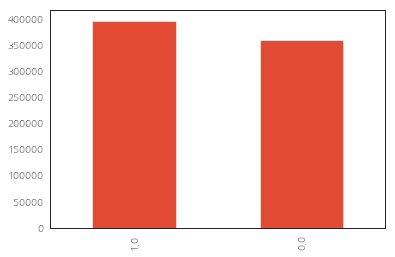

In [19]:
df_data['치석'].value_counts().plot(kind='bar') 
plt.show()

In [20]:
# 앞에서 명목형 변수의 형을 object로 모두 변경했기 때문에 컬럼 중에서 object 타입을 가진 컬럼만 뽑아서 명목형 변수의 리스트를 만든다
# 이 때, 데이터의 기본키(인덱스), 종속변수 등을 제외하고 분석하는 것이 좋음

# 단변수 탐색
category_features = [col for col in df_data.columns if df_data[col].dtypes == "object"]
print(category_features)


category_features = list(set(category_features) - set(['치석']))
print(category_features)

['성별코드', '연령대코드5세단위', '시도코드', '신장5Cm단위', '체중5Kg단위', '청력좌', '청력우', '흡연상태', '치석']
['연령대코드5세단위', '시도코드', '청력우', '체중5Kg단위', '성별코드', '신장5Cm단위', '청력좌', '흡연상태']


### 명목형 변수 EDA

In [21]:
print(len(category_features))

8


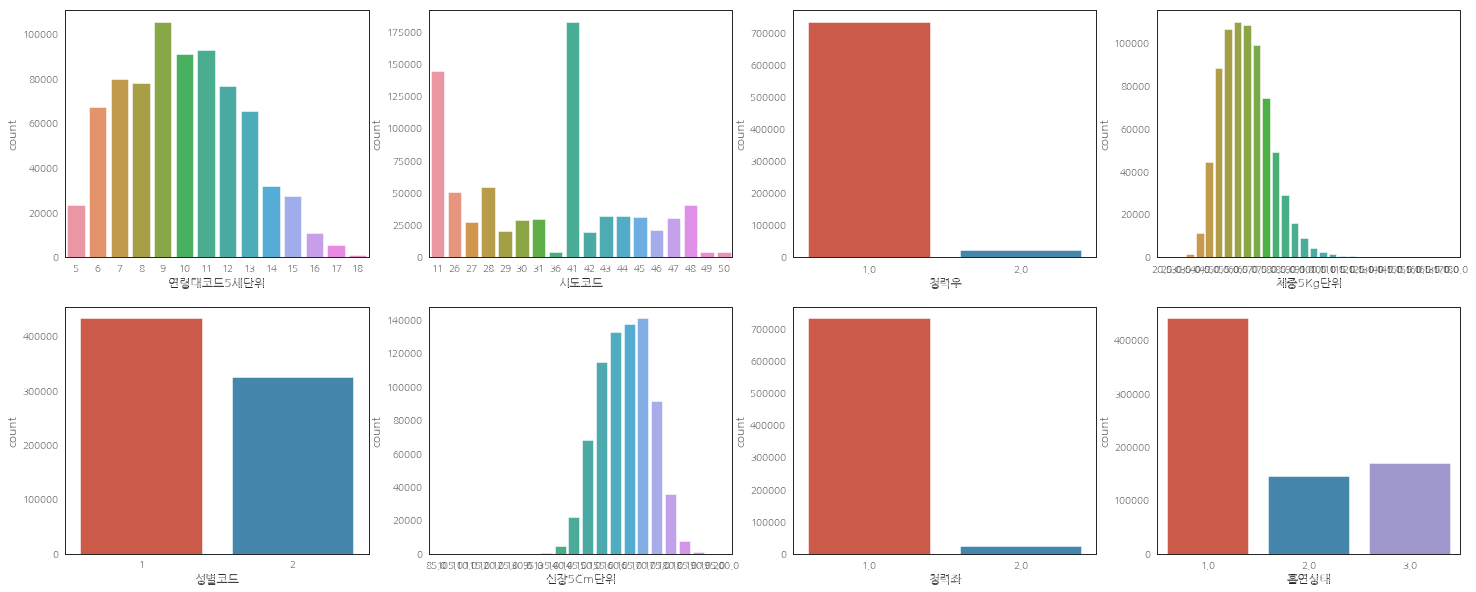

<Figure size 432x288 with 0 Axes>

In [22]:
# 그래프를 통해 명목형 변수의 분포를 체크

# for col in category_features:
#     df_data[col].value_counts().plot(kind='bar')    
#     plt.title(col)
#     plt.show()
    
fig, saxis = plt.subplots(2, 4, figsize=(25,10))
plt.figure()

# 변수별로 for문을 돌면서 countplot을 그립니다
for idx, col in enumerate(category_features):
  row_loc = idx // 4
  col_loc = idx % 4
#   print(idx, row_loc, col_loc)
  sns.countplot(x=df_data[col], data= df_data, ax = saxis[row_loc,col_loc])
#   df_data[col].value_counts().plot(kind='bar', ax = saxis[row_loc,col_loc])
  
plt.show()

In [0]:
# # 단변수 Correlation Check

# def portion_func(x):
#     sum_val = np.sum(x)
#     cnt_val = len(x)
#     portion_val = sum_val/cnt_val
#     return portion_val

  
# for col in category_features:
#     if df_data[col].dtype == 'object':
#         print('치석 Correlation by:', col)
#         print(df_data[[col, '치석']].groupby(col).agg(['sum', 'count']))

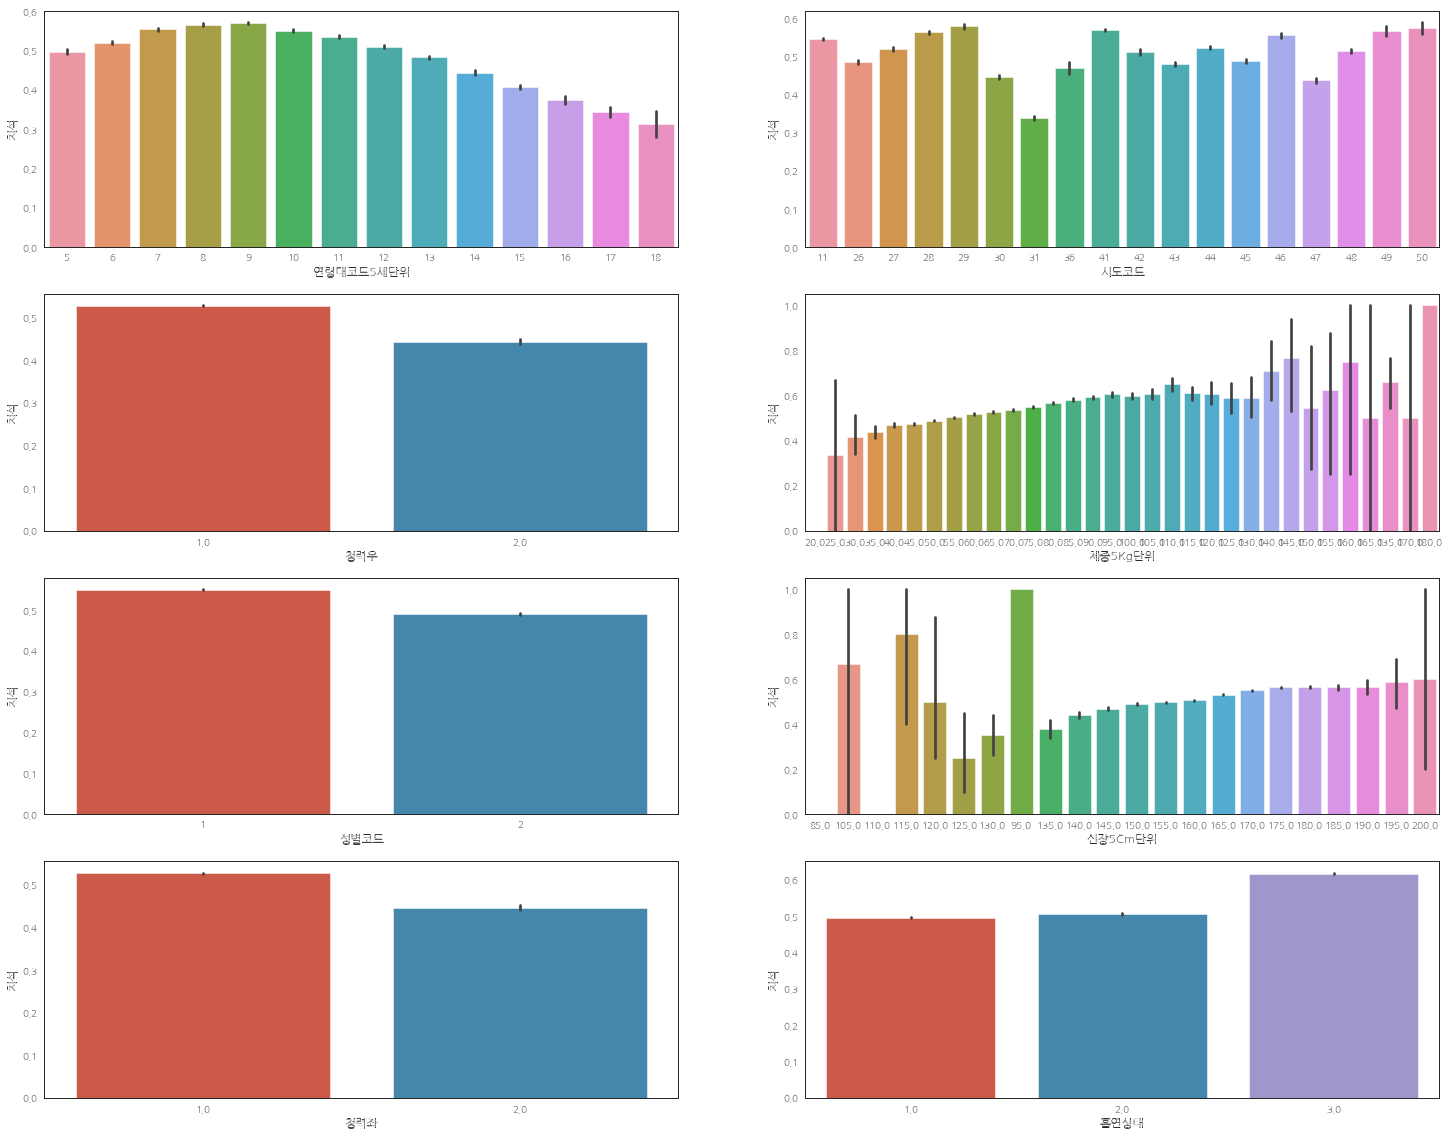

<Figure size 432x288 with 0 Axes>

In [24]:
# 이변수 탐색
# Simple Plotting
# categorical values

# fig, saxis = plt.subplots(1, 4, figsize=(20,4))

# plt.figure()

# sns.barplot(x='성별코드', y='치석', data=df_data, ax = saxis[0])
# sns.barplot(x='시도코드',y='치석', data=df_data, ax = saxis[1])
# sns.barplot(x='흡연상태',y='치석', data=df_data, ax = saxis[2])
# sns.barplot(x='흡연상태',y='치석', hue='성별코드', data=df_data, ax = saxis[3])

# plt.show()



fig, saxis = plt.subplots(4, 2, figsize=(25,20))
plt.figure()

# 변수별로 for문을 돌면서 barplot을 그립니다
for idx, col in enumerate(category_features):
  row_loc = idx // 2
  col_loc = idx % 2
#   print(idx, row_loc, col_loc)
  sns.barplot(x=col, y='치석', data= df_data, ax = saxis[row_loc,col_loc])
#   df_data[col].value_counts().plot(kind='bar', ax = saxis[row_loc,col_loc])
  
plt.show()

### 수치형 변수 EDA



In [25]:
# 앞에서 명목형 변수의 형을 object로 모두 변경했기 때문에 컬럼 중에서 object 타입을 가진 컬럼만 뽑아서 명목형 변수의 리스트를 만든다
# 이 때, 데이터의 기본키(인덱스), 종속변수 등을 제외하고 분석하는 것이 좋음

# 단변수 탐색
numeric_feature = [col for col in df_data.columns if df_data[col].dtypes != "object"]
numeric_feature = np.sort(numeric_feature)
print(len(numeric_feature)) # 총 18개

16


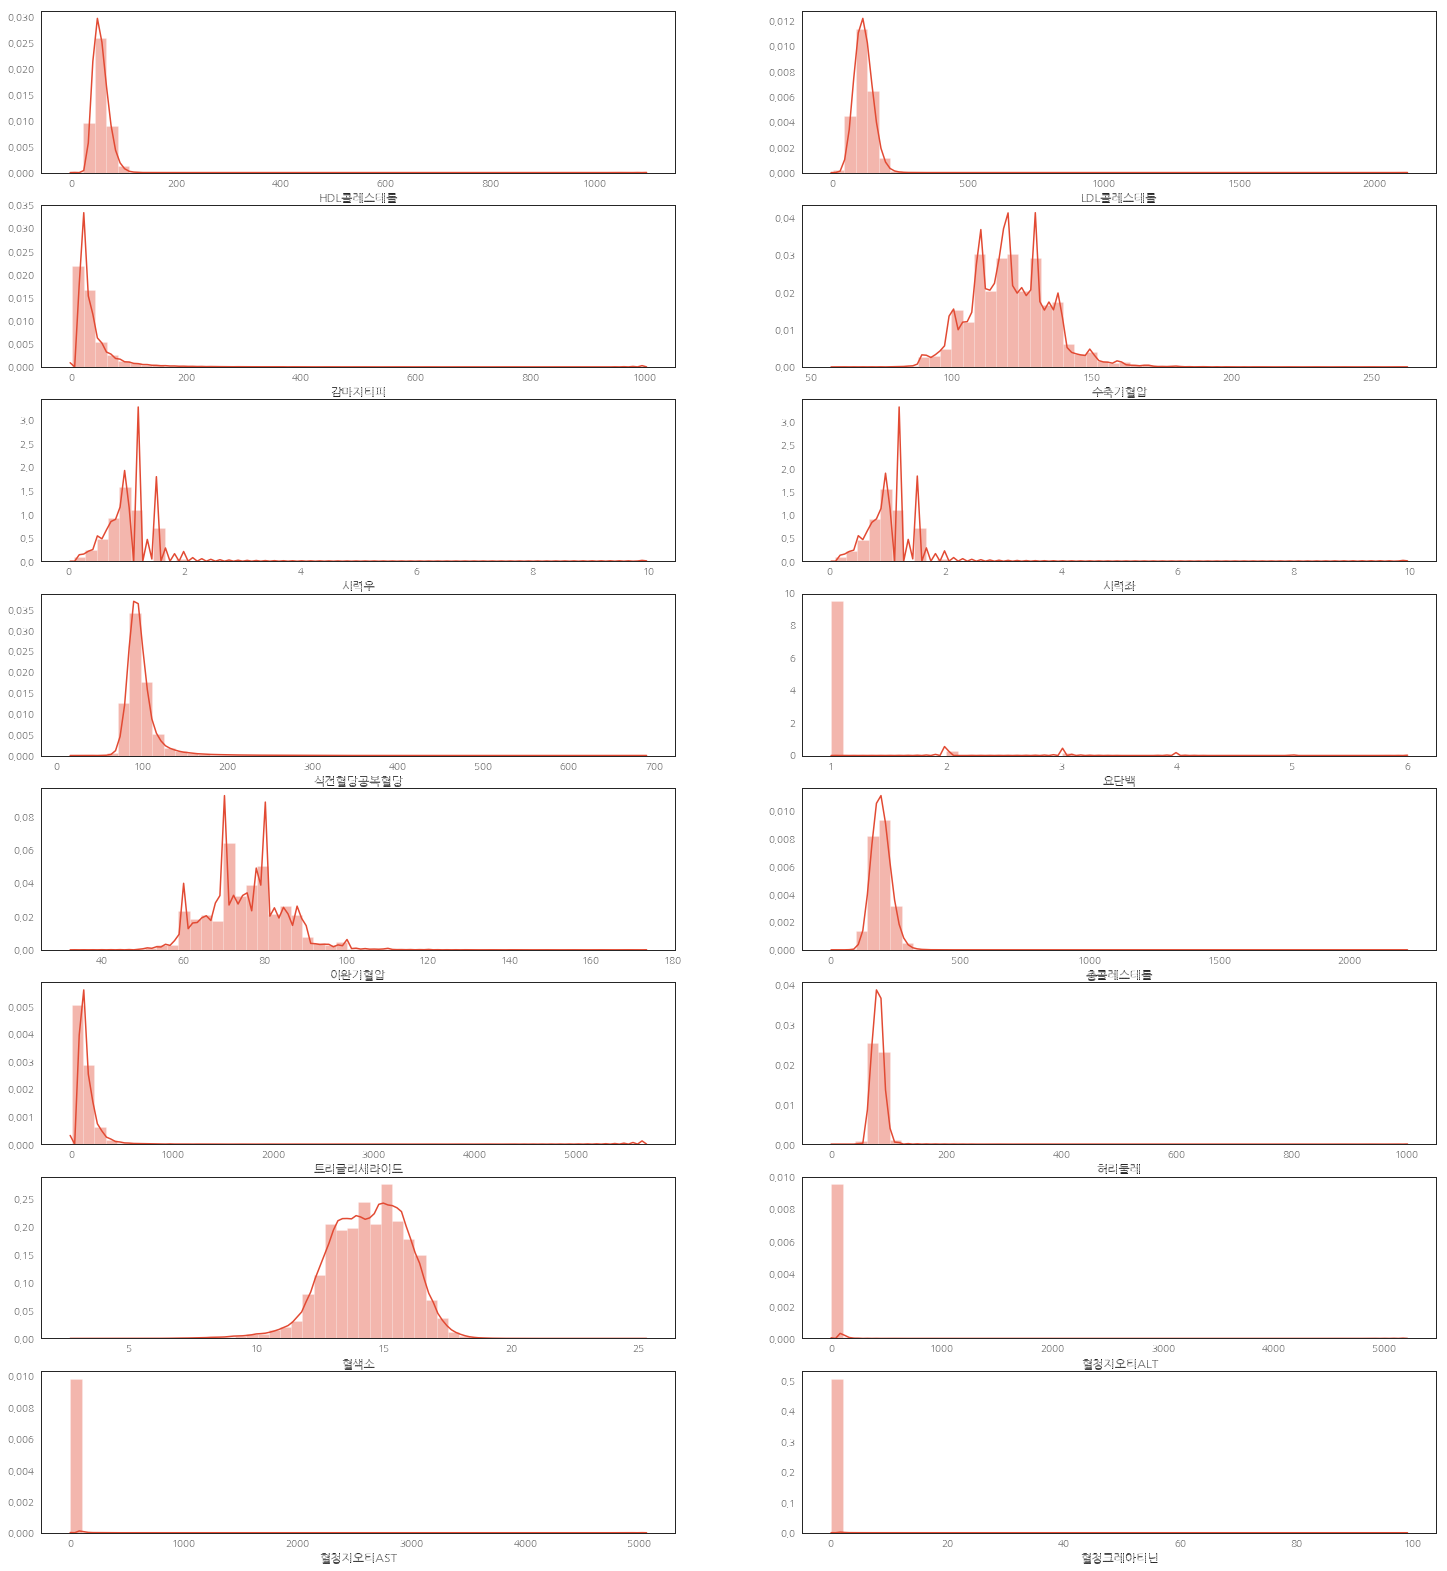

<Figure size 432x288 with 0 Axes>

In [26]:
# 단변수 탐색 - 단변수 탐색은 seaborn 패키지의 distplot 함수를 이용하면 매우 편함
# 수치형 변수만 골라냄
fig, saxis = plt.subplots(8, 2, figsize=(25,28))
plt.figure()

# 변수별로 for문을 돌면서 distplot을 그립니다


for idx, col in enumerate(numeric_feature):
    row_loc = idx // 2
    col_loc = idx % 2
#     print(idx, row_loc, col_loc)
    sns.distplot(df_data.loc[df_data[col].notnull(), col], ax = saxis[row_loc,col_loc])

plt.show()

In [27]:
# (일단 임시로~~~) null 포함 데이터 모두 삭제 
df_excl_na = df_data.dropna(how='any')
df_excl_na.head()

print(len(df_excl_na))

751452


In [28]:
df_excl_na.drop_duplicates()
df_excl_na.reset_index(inplace=True, drop=True)

print(len(df_excl_na))

df_excl_na.head()

751452


,성별코드,연령대코드5세단위,시도코드,신장5Cm단위,체중5Kg단위,허리둘레,시력좌,시력우,청력좌,청력우,수축기혈압,이완기혈압,식전혈당공복혈당,총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,혈청지오티AST,혈청지오티ALT,감마지티피,흡연상태,치석
0,1,12,48,175,70,85.0,1.2,1.2,1,1,124.0,76.0,93.0,179.0,79.0,40.0,123.0,16.8,1.0,1.0,20.0,39.0,69.0,2,1
1,1,10,31,175,70,90.0,1.5,1.5,1,1,114.0,76.0,85.0,207.0,93.0,50.0,138.0,13.9,1.0,0.8,25.0,30.0,24.0,3,0
2,1,7,46,170,80,86.0,1.5,1.0,1,1,136.0,80.0,95.0,207.0,297.0,53.0,95.0,16.7,1.0,1.0,27.0,39.0,81.0,3,0
3,1,7,41,170,80,92.0,0.6,0.4,1,1,128.0,80.0,125.0,230.0,214.0,42.0,145.0,15.3,1.0,1.0,22.0,22.0,101.0,1,1
4,1,9,26,165,65,80.0,1.5,2.0,1,1,112.0,61.0,92.0,231.0,122.0,46.0,161.0,14.4,1.0,1.0,30.0,40.0,62.0,1,0


In [29]:
# 수치형 변수들에 log를 취한 값 산출

# Feature Engineering의 일환으로 Log 값 취한 뒤 Normalization을 하여 변수명 + LN (lognorm)으로 열 추가 후 그래프 다시 그림
num_ln_cols = list(map(lambda x: str(x)+"_LN", numeric_feature))

num_pipeline = Pipeline([
        ('log_scaler', FunctionTransformer(np.log1p, validate=True)), # pipeline 내 log transformation을 위해 Function Transfomer 사용
        ('normalizer', MinMaxScaler()),
    ])

piped_np = num_pipeline.fit_transform(df_excl_na[numeric_feature])
piped_df = pd.DataFrame(piped_np, columns=num_ln_cols)

print(len(piped_df))
piped_df.head()

751452


,HDL콜레스테롤_LN,LDL콜레스테롤_LN,감마지티피_LN,수축기혈압_LN,시력우_LN,시력좌_LN,식전혈당공복혈당_LN,요단백_LN,이완기혈압_LN,총콜레스테롤_LN,트리글리세라이드_LN,허리둘레_LN,혈색소_LN,혈청지오티ALT_LN,혈청지오티AST_LN,혈청크레아티닌_LN
0,0.478886,0.592667,0.572095,0.493545,0.302229,0.302229,0.445084,0.0,0.493420,0.527673,0.435003,0.577664,0.797576,0.380913,0.300052,0.132562
1,0.513490,0.609065,0.406418,0.436185,0.357967,0.357967,0.420324,0.0,0.493420,0.554969,0.456368,0.587393,0.702567,0.348503,0.327305,0.109200
2,0.522553,0.555914,0.597555,0.556605,0.260671,0.357967,0.450945,0.0,0.525113,0.554969,0.609229,0.579654,0.794566,0.380913,0.336762,0.132562
3,0.486438,0.616121,0.632675,0.515214,0.105152,0.163375,0.526645,0.0,0.525113,0.574769,0.565979,0.591135,0.750544,0.310549,0.311660,0.132562
4,0.500540,0.631054,0.555142,0.424115,0.437464,0.357967,0.442107,0.0,0.357826,0.575584,0.491992,0.567353,0.720201,0.384053,0.349750,0.132562


In [30]:
# df_fe = df_excl_na.join(piped_df, how='inner')
# print(len(df_fe))

df_fe = pd.concat([df_excl_na, piped_df], axis=1)
df_fe.head()

,성별코드,연령대코드5세단위,시도코드,신장5Cm단위,체중5Kg단위,허리둘레,시력좌,시력우,청력좌,청력우,수축기혈압,이완기혈압,식전혈당공복혈당,총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,혈청지오티AST,혈청지오티ALT,감마지티피,흡연상태,치석,HDL콜레스테롤_LN,LDL콜레스테롤_LN,감마지티피_LN,수축기혈압_LN,시력우_LN,시력좌_LN,식전혈당공복혈당_LN,요단백_LN,이완기혈압_LN,총콜레스테롤_LN,트리글리세라이드_LN,허리둘레_LN,혈색소_LN,혈청지오티ALT_LN,혈청지오티AST_LN,혈청크레아티닌_LN
0,1,12,48,175,70,85.0,1.2,1.2,1,1,124.0,76.0,93.0,179.0,79.0,40.0,123.0,16.8,1.0,1.0,20.0,39.0,69.0,2,1,0.478886,0.592667,0.572095,0.493545,0.302229,0.302229,0.445084,0.0,0.493420,0.527673,0.435003,0.577664,0.797576,0.380913,0.300052,0.132562
1,1,10,31,175,70,90.0,1.5,1.5,1,1,114.0,76.0,85.0,207.0,93.0,50.0,138.0,13.9,1.0,0.8,25.0,30.0,24.0,3,0,0.513490,0.609065,0.406418,0.436185,0.357967,0.357967,0.420324,0.0,0.493420,0.554969,0.456368,0.587393,0.702567,0.348503,0.327305,0.109200
2,1,7,46,170,80,86.0,1.5,1.0,1,1,136.0,80.0,95.0,207.0,297.0,53.0,95.0,16.7,1.0,1.0,27.0,39.0,81.0,3,0,0.522553,0.555914,0.597555,0.556605,0.260671,0.357967,0.450945,0.0,0.525113,0.554969,0.609229,0.579654,0.794566,0.380913,0.336762,0.132562
3,1,7,41,170,80,92.0,0.6,0.4,1,1,128.0,80.0,125.0,230.0,214.0,42.0,145.0,15.3,1.0,1.0,22.0,22.0,101.0,1,1,0.486438,0.616121,0.632675,0.515214,0.105152,0.163375,0.526645,0.0,0.525113,0.574769,0.565979,0.591135,0.750544,0.310549,0.311660,0.132562
4,1,9,26,165,65,80.0,1.5,2.0,1,1,112.0,61.0,92.0,231.0,122.0,46.0,161.0,14.4,1.0,1.0,30.0,40.0,62.0,1,0,0.500540,0.631054,0.555142,0.424115,0.437464,0.357967,0.442107,0.0,0.357826,0.575584,0.491992,0.567353,0.720201,0.384053,0.349750,0.132562


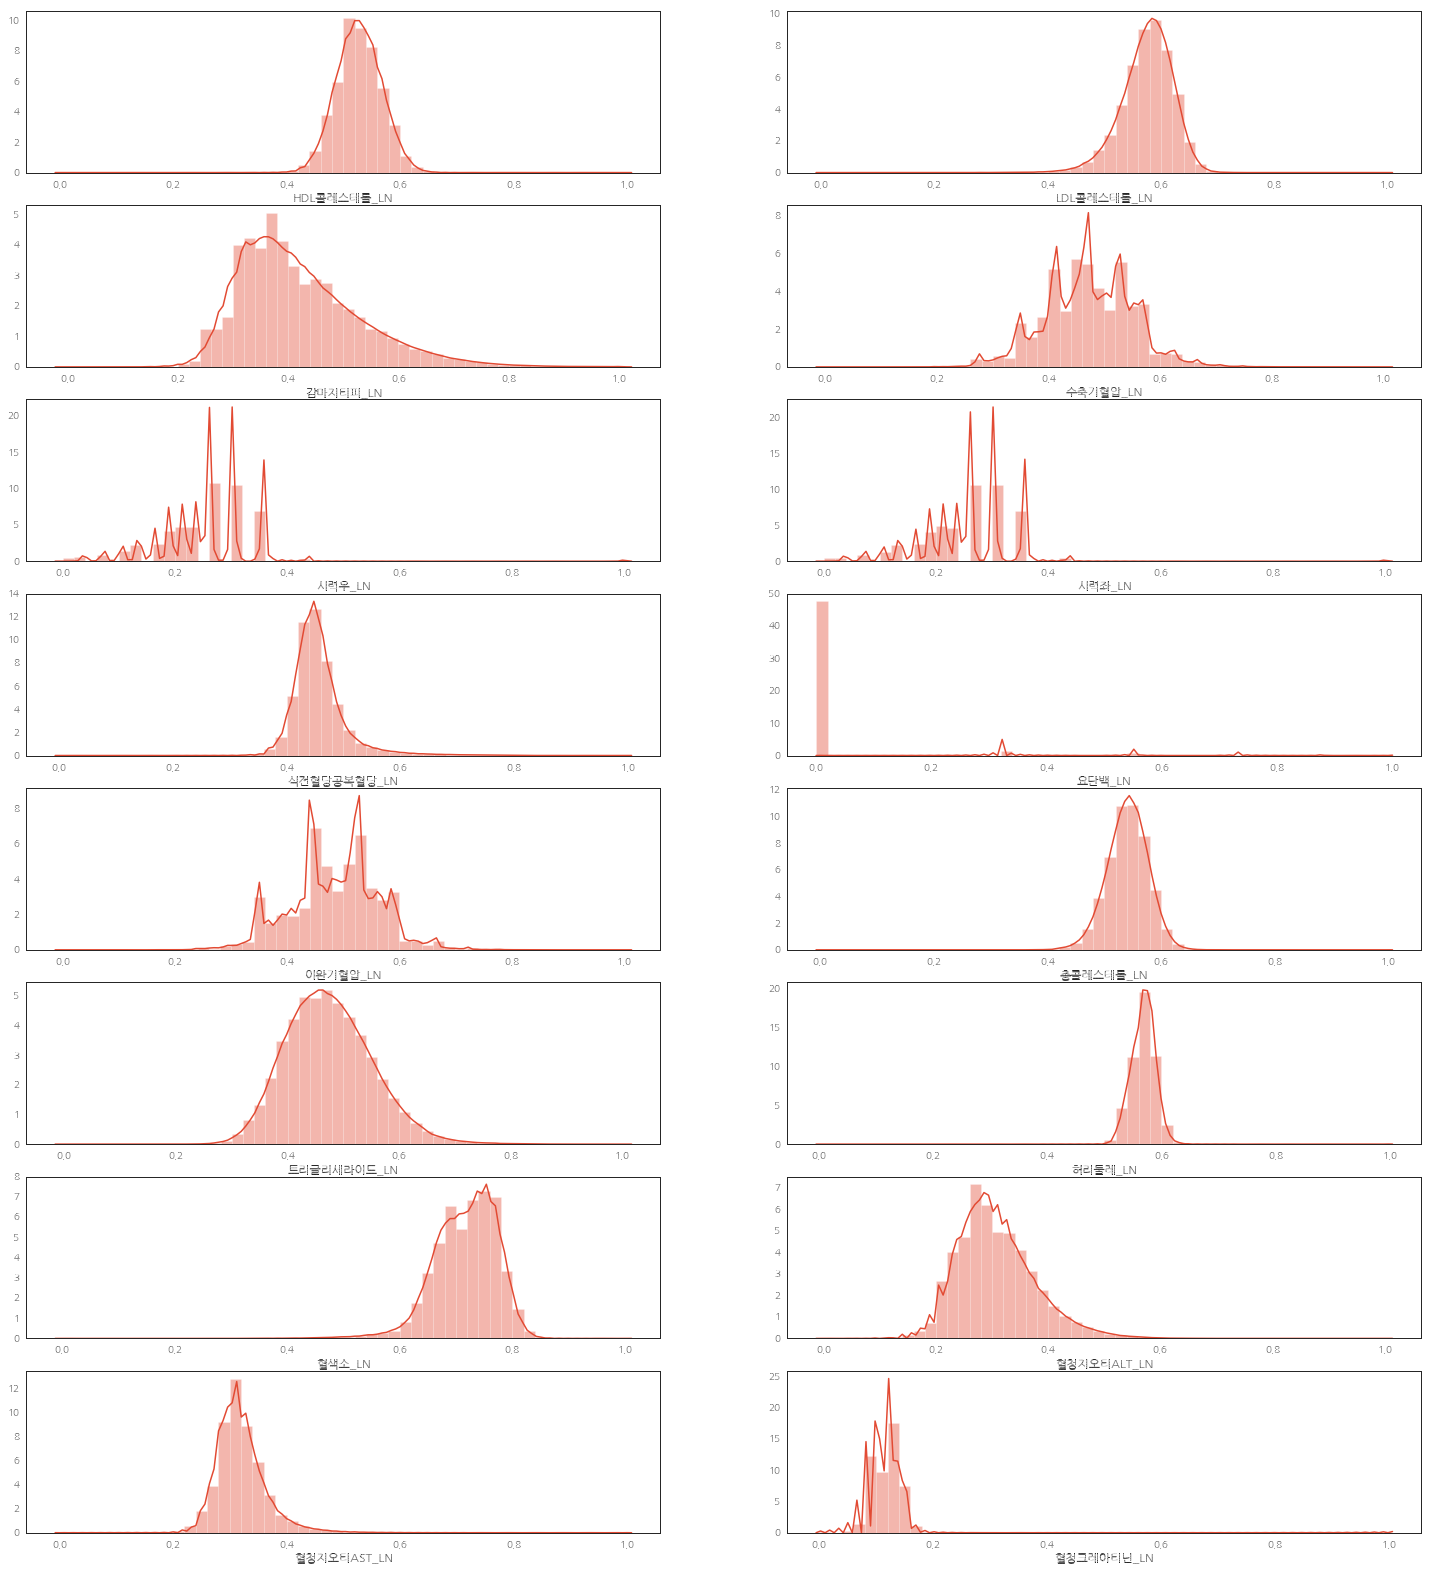

<Figure size 432x288 with 0 Axes>

In [31]:
# 단변수 탐색 with log 변형 변수
# 수치형 변수만 골라냄
fig, saxis = plt.subplots(8, 2, figsize=(25,28))
plt.figure()

# 변수별로 for문을 돌면서 distplot을 그립니다


for idx, col in enumerate(num_ln_cols):
    row_loc = idx // 2
    col_loc = idx % 2
#     print(idx, row_loc, col_loc)
    sns.distplot(df_fe.loc[df_fe[col].notnull(), col], ax = saxis[row_loc,col_loc])

plt.show()


In [0]:
# Calculate information value
def calc_iv(df, feature, target, pr=False):
    """
    Set pr=True to enable printing of output.
    
    Output: 
      * iv: float,
      * data: pandas.DataFrame
    """

    lst = []

    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())


    iv = data['IV'].sum()
    # print(iv)

    return iv, data

In [0]:
# Data Sampling으로 몇 개 추려서 Information Value Test

df_sample = df_fe.sample(10000).copy()

iv, df_iv = calc_iv(df_sample, '흡연상태', '치석')

In [35]:
df_iv.head()

,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,흡연상태,1.0,5913,2989,2924,0.5913,0.494504,0.631123,0.555471,0.127685,0.009660
1,흡연상태,2.0,1887,935,952,0.1887,0.504505,0.197424,0.180851,0.087680,0.001453
2,흡연상태,3.0,2200,812,1388,0.2200,0.630909,0.171453,0.263678,-0.430421,0.039696


In [36]:
df_iv[df_iv['Bad Rate'] > 0.0]

,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,흡연상태,1.0,5913,2989,2924,0.5913,0.494504,0.631123,0.555471,0.127685,0.009660
1,흡연상태,2.0,1887,935,952,0.1887,0.504505,0.197424,0.180851,0.087680,0.001453
2,흡연상태,3.0,2200,812,1388,0.2200,0.630909,0.171453,0.263678,-0.430421,0.039696


In [44]:
! pip install woe

In [0]:
# Calculate IV Setting

# import plotly.plotly as py
# import plotly.graph_objs as go
# import plotly
# import plotly.figure_factory as ff
# from plotly.offline import init_notebook_mode, iplot
# init_notebook_mode(connected=True)
# plotly.offline.init_notebook_mode(connected=True)

from pandas import Series
import scipy.stats.stats as stats
import traceback
import string
import woe
from woe.eval import plot_ks

max_bin = 20
force_bin = 3

In [0]:
# Define a binning function for continous independent variables
def mono_bin(Y, X, n = max_bin):
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)
  
# Define a binning function for categorical independent variables
def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

# Calculate Information Values
def calc_iv(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [0]:
final_iv, IV = calc_iv(df_fe,df_fe['치석'])
final_iv

In [0]:
# IV Plotting
data = [go.Bar(
            x=final_iv['VAR_NAME'],
            y=final_iv['WOE'],
            text=final_iv['VAR_NAME'],
            marker=dict(
            color='rgb(158,20,25)',
            line=dict(
            color='rgb(8,48,107)',
            width=1.5,
        )
    ),
    opacity=0.6
    )]


layout = go.Layout(
    title='Weight of Evidence(WOE)',
        xaxis=dict(
        title='Features',
            tickangle=-45,
        tickfont=dict(
            size=10,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Weight of Evidence(WOE)',
        titlefont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
)

plotly.offline.iplot({
    "data": data,'layout':layout
})

### Feature Engineering 변수 추가

In [0]:
df_fe.head()

In [0]:
# 기존 수치형 변수들을 LN 변수들로 치환
# df_fe.drop(columns=numeric_feature, axis=1, inplace=True)

# BMI 변수 추가
df_fe["BMI"] = df_fe["체중5Kg단위"]/(df_fe["신장5Cm단위"]*df_fe["신장5Cm단위"])

In [0]:
df_fe.columns

In [0]:
# df_fe['치석'].astype('float64').corr(df_fe['허리둘레_LN'])
df_fe['치석'].astype('float64').corr(df_fe['성별코드'])

In [0]:
from pprint import pprint as pp

corr_dict = {}

for i in num_ln_cols:
    corr_dict[i] = df_fe['치석'].astype('float64').corr(df_fe[i])

pp(corr_dict)

In [0]:
# 데이터 간의 상관관계 체크
# 수치형변수들과 Survived 변수의 상관관계 Matrix 시각화
g = sns.heatmap(df_fe.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

In [0]:
category_features

In [0]:
df_onehot = pd.get_dummies(df_fe, columns=['청력우', '청력좌', '시도코드', '신장5Cm단위', '체중5Kg단위', '흡연상태', '연령대코드5세단위', '성별코드'])
df_onehot.head()

In [0]:
# from pprint import pprint as pp

# corr_oh_dict = {}

# for i in df_onehot.columns:
#     corr_oh_dict[i] = df_onehot['치석'].corr(df_onehot[i])

# pp(corr_oh_dict)

In [0]:
df_x = df_onehot[df_onehot.columns.difference(['치석'])]
df_y = df_onehot['치석'].astype('float64')

In [0]:
np_x = df_x.values
np_y = df_y.values

print(np_x[:2])
print(np_y[:2])

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(np_x, np_y, test_size = 0.3, random_state = 42)

In [0]:
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer

# num_pipeline = Pipeline([
#         ('mixmax_scaler', MinMaxScaler()),
#     ])

In [0]:
# x_train = num_pipeline.fit_transform(x_train)
# x_test = num_pipeline.fit_transform(x_test)

In [0]:
display(x_train[:2])

In [0]:
# display(x_train.head())
# display(x_test.head())
# display(y_train.head())
# display(y_test.head())
display(x_train.shape)
display(y_train.shape)
display(x_test.shape)
display(y_test.shape)

In [0]:
print(len(x_train), len(x_test), len(y_train), len(y_test))

In [0]:
from sklearn import tree, linear_model, naive_bayes, ensemble

# evaluation package
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc

In [0]:
model_lr = linear_model.LogisticRegression()
model_lr.fit(x_train, y_train)

In [0]:
y_pred_lr = model_lr.predict(x_test)
print("Accuracy: {:.5f}".format(accuracy_score(y_test, y_pred_lr)))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_lr))
print("Classification Report Matrix: \n", classification_report(y_test, y_pred_lr))

roc_auc_lr = roc_auc_score(y_test, y_pred_lr)
print(roc_auc_lr)

In [0]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_lr)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
model_rf = ensemble.RandomForestClassifier()
model_rf.fit(x_train, y_train)

In [0]:
y_pred_rf = model_rf.predict(x_test)
print("Accuracy: {:.5f}".format(accuracy_score(y_test, y_pred_rf)))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report Matrix: \n", classification_report(y_test, y_pred_rf))

In [0]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_rf)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
important_features_dict = {}
for x,i in enumerate(model_rf.feature_importances_):
    important_features_dict[x]=i


important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

print(sorted(model_rf.feature_importances_, reverse=True))
print('Most important features: %s'%important_features_list)

In [0]:
model_dt = tree.DecisionTreeClassifier()
model_dt.fit(x_train, y_train)

In [0]:
y_pred_dt = model_dt.predict(x_test)
print("Accuracy: {:.5f}".format(accuracy_score(y_test, y_pred_dt)))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_dt))
print("Classification Report Matrix: \n", classification_report(y_test, y_pred_dt))

In [0]:
import keras
# Deep Learning Model 로드
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation 
from keras.wrappers.scikit_learn import KerasClassifier

In [0]:
# Deep Learning 평가를 위한 평가 함수 정의
from keras import backend as K

def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [0]:
x_train.shape
print(x_train.shape[0])
print(x_train.shape[1])

In [0]:
lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)
activation = lrelu
input_dim = x_train.shape[1]
batch_size = 64
epochs = 10

ffn_model = Sequential()
  
# 첫 번째 Layer (Input layer)
ffn_model.add(Dense(input_dim=input_dim, init='glorot_uniform', activation=activation, output_dim=128))
# ffn_model.add(Dropout(0.3)) # 30% 정도를 Drop 

# 두 번째 Layer (Hidden layer 1)
ffn_model.add(Dense(output_dim=128, init='glorot_uniform', activation=activation))
# ffn_model.add(Dropout(0.3)) # 30% 정도를 Drop 

# 세 번째 Layer (Hidden layer 2)
ffn_model.add(Dense(output_dim=256, init='glorot_uniform', activation=activation))
# ffn_model.add(Dropout(0.3)) # 30% 정도를 Drop 

# 네 번째 Layer (Hidden layer 3)
ffn_model.add(Dense(output_dim=512, init='glorot_uniform', activation=activation))
# ffn_model.add(Dropout(0.3)) # 30% 정도를 Drop 

# 다섯 번째 Layer (Output layer)
ffn_model.add(Dense(output_dim=1))
ffn_model.add(Activation("sigmoid"))

# Cost function 및 Optimizer 설정 # binary class 분류이므로 binary_crossentropy 사용 # Adam optimizer 사용
# ffn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, f1score])
ffn_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', precision, recall, f1score])
                      
# model training
hist = ffn_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

In [0]:
y_pred_dl = ffn_model.predict(x_test)
y_pred_dl = (y_pred_dl>0.5)

In [0]:
print("Accuracy: {:.5f}".format(accuracy_score(y_test, y_pred_dl)))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_dl))
print("Classification Report Matrix: \n", classification_report(y_test, y_pred_dl))

roc_auc_dl = roc_auc_score(y_test, y_pred_dl)
print(roc_auc_dl)

In [0]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_dl)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()